In [0]:
import numpy as np
import pandas as pd
import pylab as plt 

from google.colab import drive
import sqlite3
import seaborn as sns

from scipy.stats import binned_statistic, binned_statistic_2d
from matplotlib.colors import BoundaryNorm, LogNorm
from statsmodels.stats.proportion import proportion_confint


from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc , confusion_matrix
from sklearn.model_selection import GridSearchCV

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [0]:
drive.mount('/content/gdrive')

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/UD/Sbux')
import sbux_functions as sb 

In [0]:

portfolio=pd.read_pickle(r'/content/gdrive/My Drive/UD/Sbux/data/portfolio.pkl')
profile=pd.read_pickle(r'/content/gdrive/My Drive/UD/Sbux/data/profile.pkl')
df=pd.read_pickle(r'/content/gdrive/My Drive/UD/Sbux/data/pers_offers_final.pkl')
transactions_during_offer=pd.read_pickle(r'/content/gdrive/My Drive/UD/Sbux/data/trans_do.pkl')
transactions_outside_offer=pd.read_pickle(r'/content/gdrive/My Drive/UD/Sbux/data/trans_oo.pkl')

# 1. EDA of customer data

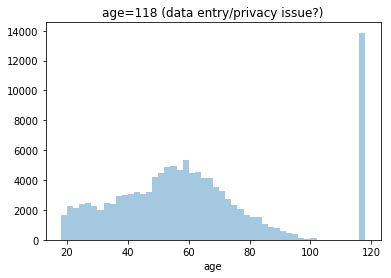

In [0]:
#profile['age'].hist()

sns.distplot(df['age'],kde=False);
plt.title('age=118 (data entry/privacy issue?)');

In [0]:
df['incorrect']=df.age>102


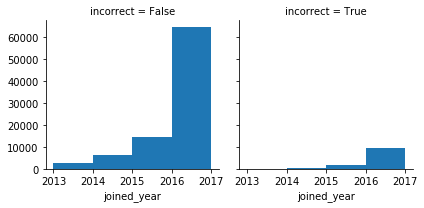

In [0]:
g = sns.FacetGrid(df, col="incorrect")
g.map(plt.hist, "joined_year",bins=range(2013,2018));

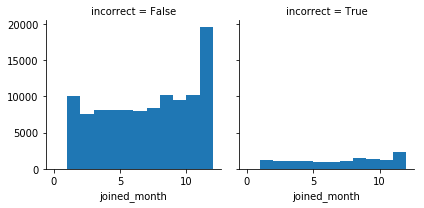

In [0]:
g = sns.FacetGrid(df, col="incorrect")
g.map(plt.hist, "joined_month",bins=range(0,13));


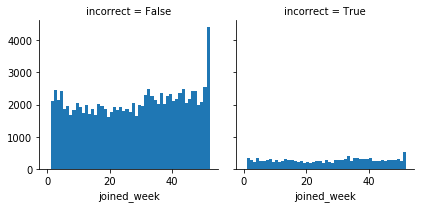

In [0]:
g = sns.FacetGrid(df, col="incorrect")
g.map(plt.hist, "joined_week",bins=range(0,53));



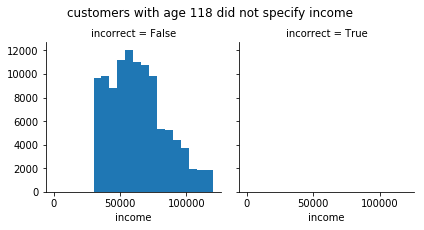

In [0]:
g = sns.FacetGrid(df, col="incorrect")
g.map(plt.hist, "income",bins=15);
plt.suptitle('customers with age 118 did not specify income ',y=1.05);


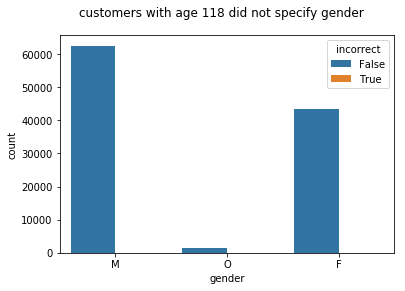

In [0]:
sns.countplot(x='gender',hue='incorrect',data=df)
plt.suptitle('customers with age 118 did not specify gender');

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


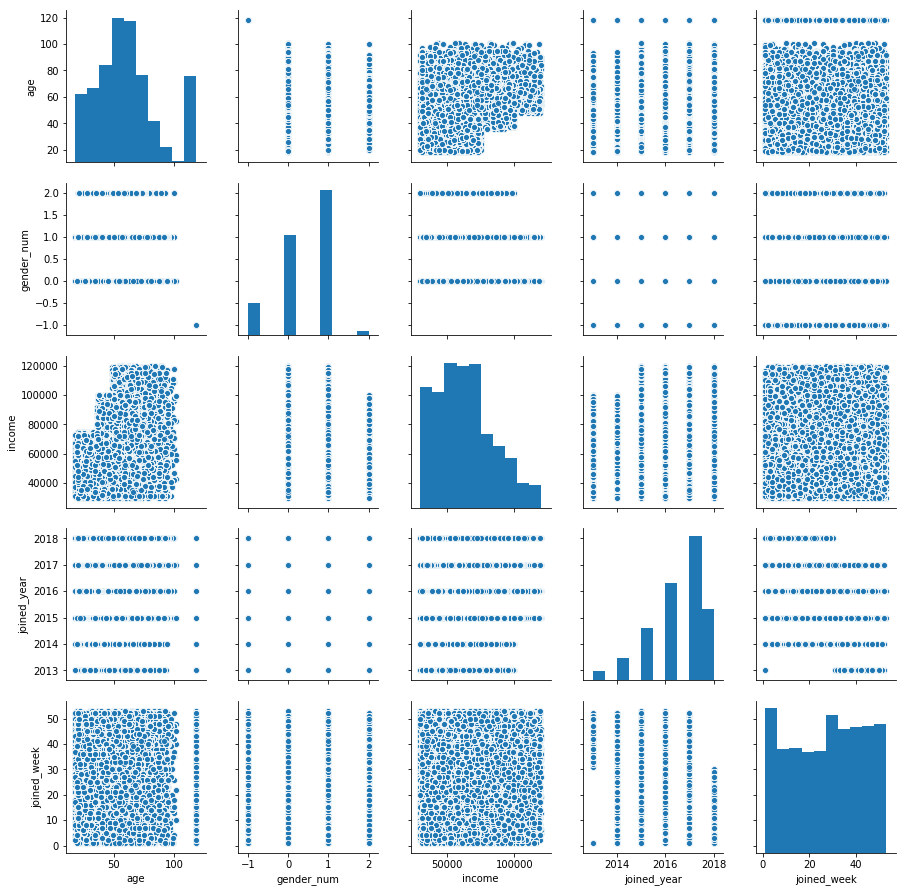

In [0]:
sns.pairplot(df[['age','gender_num','income','joined_year','joined_week']])
#profile.describe()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


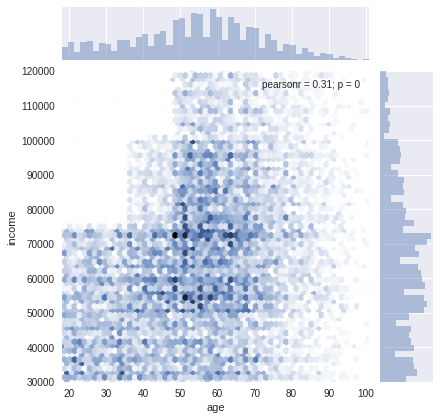

In [0]:
sns.jointplot('age', 'income', kind="hex",data=df[(df.incorrect==False)])

In [0]:
print('pearson')
print(profile.loc[(profile.incorrect==False),['age','income']].corr(method='pearson'))
print()
print()

print('spearman')
print(profile.loc[(profile.incorrect==False),['age','income']].corr(method='spearman'))
print()
print()

print('kendall')
print(profile.loc[(profile.incorrect==False),['age','income']].corr(method='kendall'))



pearson
             age    income
age     1.000000  0.307425
income  0.307425  1.000000


spearman
             age    income
age     1.000000  0.298572
income  0.298572  1.000000


kendall
             age    income
age     1.000000  0.204334
income  0.204334  1.000000


[18, 120, 20000, 120000]

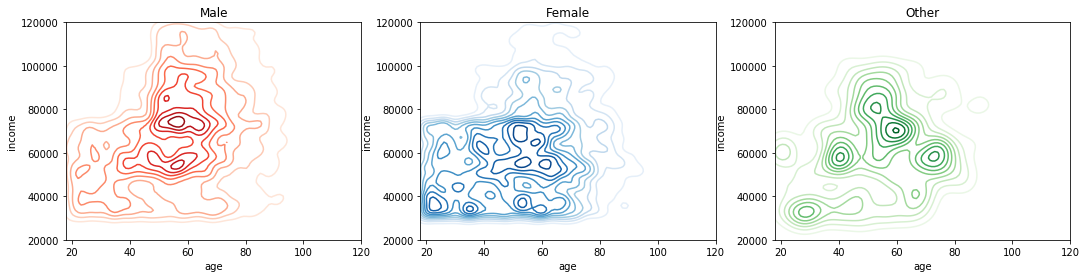

In [0]:
plt.figure(figsize=(18,4))
plt.subplot(131)
sns.kdeplot(df.loc[df.gender_num==0,"age"],df.loc[df.gender_num==0, "income"],
           cmap="Reds");
plt.title('Male')
plt.axis([18,120,20000,120000])

plt.subplot(132)
sns.kdeplot(df.loc[df.gender_num==1,"age"],df.loc[df.gender_num==1, "income"],
           cmap="Blues");
plt.title('Female')
plt.axis([18,120,20000,120000])

plt.subplot(133)
sns.kdeplot(df.loc[df.gender_num==2,"age"],df.loc[df.gender_num==2, "income"],
           cmap="Greens");
plt.title('Other')
plt.axis([18,120,20000,120000])


In [0]:
# gg=df.groupby(['gender_num'])[['received','completed','comp_not_viewed','viewed','rewarded' , 'web', 'email', 'mobile', 'social']].agg('sum')

In [0]:
# gender=gg.loc[:,['viewed','rewarded','completed','comp_not_viewed', 'web', 'email', 'mobile', 'social'  ]].divide(gg.loc[:,'received'],axis=0)
# display(gender)



In [0]:
offers_start_times=np.unique(df['offer_received'].dropna().values)
display(offers_start_times)

array([  0., 168., 336., 408., 504., 576.])

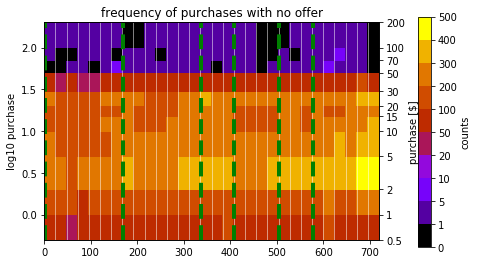

In [0]:
xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500])

fig,ax,ax1,ym,yM=sb.bin_transactions(transactions_outside_offer,'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases with no offer');

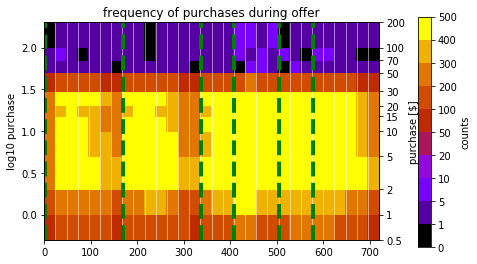

In [0]:
xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500])

fig,ax,ax1,ym,yM=sb.bin_transactions(transactions_during_offer,'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases during offer');

In [0]:
df['Avg_pay_outside'].max()

3.573474178403756

'ca253788781646f0a02492a0447ecf17'

In [0]:
def test_offers_of_customer(piv,customer,transactions_outside_offer,yc=0,step=0.1,plot_transactions=True,plot_offer_name=True):
  # plots the offers and the transactions for a customer
  
  gg=piv.loc[(piv.person==customer),'offer_received' ].drop_duplicates()
  ind=gg.index.values

  viewed_offers=[]

  v_off_times=np.zeros((ind.shape[0],2))
  v_off_set=set([])

  c=0

  for n in ind:
    hh=plt.plot([piv.loc[n,'offer_received'],piv.loc[n,'offer_end']  ],[yc,yc],'o-',alpha=0.6)
    color=hh[0].get_color()
    
    if plot_offer_name:
      plt.text(  (piv.loc[n,'offer_received']+piv.loc[n,'offer_end'])/2,yc-.2, piv.loc[n,'offer'] );
    
    if not np.isnan(piv.loc[n,'offer_viewed']):
      plt.plot([piv.loc[n,'offer_viewed'],piv.loc[n,'offer_end']  ],[yc,yc],'.-',alpha=1.0,color=color)
      cur_offer=piv.loc[n,'offer']
      viewed_offers.append(cur_offer )
      v_off_times[c,0]=piv.loc[n,'offer_viewed']
      v_off_times[c,1]=piv.loc[n,'offer_end']
      v_off_set=v_off_set.union(set( range(int(piv.loc[n,'offer_viewed']), int(piv.loc[n,'offer_end'])+0) ))
      
      if plot_transactions:
        df=piv.loc[((piv.person==customer) & (piv.offer==cur_offer) ),:]
        plt.plot(df['time'],df['payments'],'o',color=color,alpha=0.3)

      
      c+=1


    yc+=step
  v_off_times=v_off_times[0:c,:]

  diff=np.diff(np.array(list(v_off_set)) )
  diff[diff>1]=0
  overlapping_offers_time=diff.sum()

  if plot_transactions:
#     df=piv.loc[(piv.person==customer)]
#     plt.plot(df['time'],df['payments'],'o',color='k',alpha=0.3)
    
    to=transactions_outside_offer.loc[(transactions_outside_offer.person==customer)]
    plt.plot(to['time'],to['payments'],'d',color='k',alpha=0.3)
      
  
  plt.xlabel('hours');
  plt.ylabel('purchases');
  
  
  return(viewed_offers,v_off_times,overlapping_offers_time)


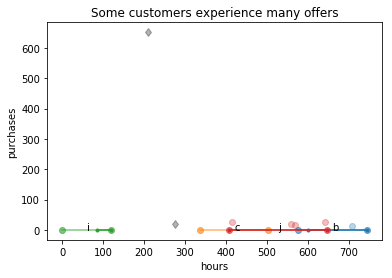

In [0]:
df.columns
c1=df.loc[( (df['Avg_pay_outside']>0.8) ),'person'].iloc[30]
c1

#sb.plot_offers_of_customer(df,c1,yc=0,step=0.1,plot_transactions=True);
test_offers_of_customer(df,c1,transactions_outside_offer,yc=0,step=0.1,plot_transactions=True);

plt.title('Some customers experience many offers');

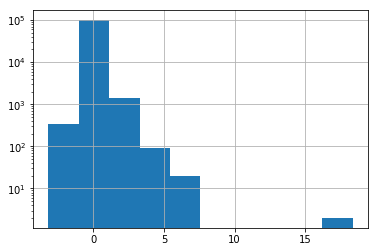

In [0]:
# df['Avg_pay_outside'].hist()
df['Avg_D_O'].hist()
plt.yscale('log')

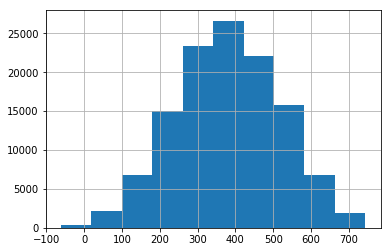

In [0]:
df['tot_not_offers_time'].hist()


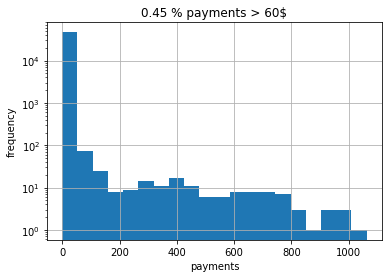

In [0]:
transactions_outside_offer['payments'].hist(bins=20);
plt.yscale('log');
plt.xlabel('payments');
plt.ylabel('frequency');
frac_large_payments=100.*transactions_outside_offer.loc[transactions_outside_offer.payments>60,'payments'].shape[0]/transactions_outside_offer.shape[0]
plt.title('%3.2g %% payments > 60$' % frac_large_payments );


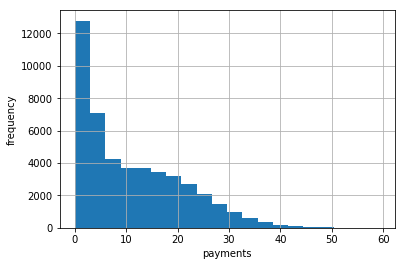

In [0]:
transactions_outside_offer.loc[transactions_outside_offer.payments<60,'payments'].hist(bins=20);
# plt.yscale('log');
plt.xlabel('payments');
plt.ylabel('frequency');

In [0]:
ltc=np.unique(transactions_outside_offer.loc[transactions_outside_offer.payments>60,'person'])

In [0]:
iltc=piv.loc[piv.person.isin(ltc),'person'].drop_duplicates().index

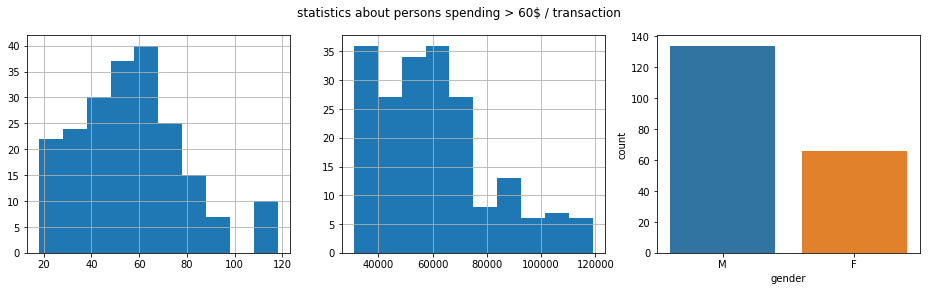

In [0]:
plt.figure(figsize=(16,4))
plt.subplot(131)
piv.loc[iltc,'age'].hist();

plt.subplot(132)
piv.loc[iltc,'income'].hist();

plt.subplot(133)
sns.countplot(x='gender',data=piv.loc[iltc,:])
plt.suptitle('statistics about persons spending > 60$ / transaction');

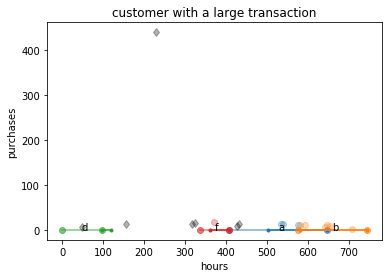

In [0]:

test_offers_of_customer(df,ltc[1],transactions_outside_offer,yc=0,step=0.1,plot_transactions=True);
plt.title('customer with a large transaction');

In [0]:
stc=list(set(piv.person)-set(ltc))

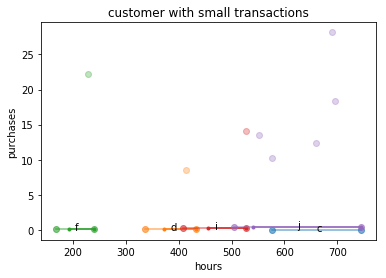

In [0]:
# cu=stc[2]
cu="0009655768c64bdeb2e877511632db8f"

test_offers_of_customer(df,cu,transactions_outside_offer,yc=0,step=0.1,plot_transactions=True);
plt.title('customer with small transactions');

In [0]:


trans_cols=[ 'person','offer','offer_received','age','income','gender','duration','duration_effective','reward',
            'user_time','social','web','mobile','difficulty',  'duration_effective', 'time', 'payments',  
             'Tpay_offer','Tpay_out','Npay_out',
       'Npay_offer', 'tot_gross_offer_time', 'tot_net_offers_time',
       'tot_not_offers_time', 'Avg_pay_offer', 'Avg_pay_outside', 'Avg_D_O']

In [0]:
df['tot_net_offers_time']=df['tot_net_offers_time'].fillna(0)
#,'reward','Tpay_offer','Tpay_out','Npay_out','Npay_offer']].fillna(0,inplace=True)


In [0]:
ind_off=df.drop_duplicates(subset=['person','offer','offer_received'],inplace=False).index
ind_view=df[(df.viewed==True)].index
ind=ind_view.intersection(ind_off)
df['Tpay_out']=df['Tpay_out'].fillna(0)
df['Npay_out']=df['Npay_out'].fillna(0)
df['Tpay_offer']=df['Tpay_offer'].fillna(0)
df['Npay_offer']=df['Npay_offer'].fillna(0)

df['Avg_pay_outside']=df['Tpay_out']/df['tot_not_offers_time']
df['Avg_D_O']= df['Avg_pay_offer'] - df['Avg_pay_outside']
# display(df.loc[df.person==stc[2],trans_cols])
# df.loc[ind,trans_cols]

print(df.loc[ind,trans_cols].shape)
display(df.loc[ind,trans_cols].head())
display(df.loc[ind,col_bin].head())


(49135, 27)


,person,offer,offer_received,age,income,gender,duration,duration_effective,reward,user_time,...,Tpay_offer,Tpay_out,Npay_out,Npay_offer,tot_gross_offer_time,tot_net_offers_time,tot_not_offers_time,Avg_pay_offer,Avg_pay_outside,Avg_D_O
1,0009655768c64bdeb2e877511632db8f,d,336.0,33,72000.0,M,4.0,60.0,NaN,461,...,8.57,0.00,0.0,1.0,1200.0,388.0,356.0,0.142833,0.000000,0.142833
2,0009655768c64bdeb2e877511632db8f,f,168.0,33,72000.0,M,3.0,48.0,NaN,461,...,22.16,0.00,0.0,1.0,1200.0,388.0,356.0,0.461667,0.000000,0.461667
3,0009655768c64bdeb2e877511632db8f,i,408.0,33,72000.0,M,5.0,72.0,5.0,461,...,14.11,0.00,0.0,1.0,1200.0,388.0,356.0,0.195972,0.000000,0.195972
4,0009655768c64bdeb2e877511632db8f,j,504.0,33,72000.0,M,10.0,204.0,2.0,461,...,82.76,0.00,0.0,5.0,1200.0,388.0,356.0,0.405686,0.000000,0.405686
9,00116118485d4dfda04fdbaba9a87b5c,i,168.0,118,NaN,None,5.0,72.0,NaN,92,...,0.00,4.09,3.0,0.0,72.0,73.0,671.0,NaN,0.006095,NaN


,web,mobile,social
1,True,True,False
2,False,True,True
3,True,True,True
4,True,True,True
9,True,True,True


In [0]:
data=df.loc[ind,trans_cols].dropna(axis=0).copy()

data[col_bin]=data[col_bin].astype(int)
data=data.drop(columns=['person'])
col_cat=['gender','offer']
col_bin=['web',  'mobile', 'social'  ]
Y_col='Avg_D_O'

def prepare_X(df,col_bin,Y_col,col_cat):
#   df[col_bin]=df[col_bin].astype(int)
#   Y=df[Y_col].astype(int)
  Y=df[Y_col]
  X=df.drop(columns=Y_col)

  col_numbin=list(set(X.columns)-set(col_cat))

  X_onehot=pd.get_dummies(X[col_cat])
  col_oneh=X_onehot.columns
  X=pd.concat((X[col_numbin],X_onehot),axis=1)
  
  return(X,Y)

X,Y= prepare_X(data.dropna(axis=1),col_bin,Y_col,col_cat)


In [0]:
# data.head()
# df[col_bin]=df[col_bin].astype(int)

data=df.loc[ind,trans_cols].dropna(axis=0).copy()
data.loc[df['mobile'].isnull(),:].index

Int64Index([], dtype='int64')

In [0]:
data=df.loc[ind,trans_cols].dropna(axis=0).copy()

data[col_bin]=data[col_bin].astype(int)
data=data.drop(columns=['person'])
col_cat=['gender','offer']
col_bin=['web',  'mobile', 'social'  ]
Y_col='Avg_D_O'

def prepare_X(df,col_bin,Y_col,col_cat):
#   df[col_bin]=df[col_bin].astype(int)
  Y=df[Y_col].astype(int)
  X=df.drop(columns=Y_col)

  col_numbin=list(set(X.columns)-set(col_cat))

  X_onehot=pd.get_dummies(X[col_cat])
  col_oneh=X_onehot.columns
  X=pd.concat((X[col_numbin],X_onehot),axis=1)
  
  return(X,Y)

X,Y= prepare_X(data.dropna(axis=1),col_bin,Y_col,col_cat)


ValueError: ignored

In [0]:
# cu="0009655768c64bdeb2e877511632db8f"
# display(df.loc[df.person==cu,trans_cols])

In [0]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=5, random_state=0).fit(df)

In [0]:
df.columns

Index(['person', 'offer', 'offer_completed', 'offer_received', 'offer_viewed',
       'reward', 'difficulty', 'duration', 'offer_type', 'web', 'email',
       'mobile', 'social', 'duration_hours', 'offer_end', 'duration_viewed',
       'duration_effective', 'viewed', 'rewarded', 'received',
       'comp_not_viewed', 'completed', 'time', 'payments', 'Tpay_out',
       'Npay_out', 'Tpay_offers_tot', 'Npay_offers_tot', 'Tpay_offer',
       'Npay_offer', 'tot_gross_offer_time', 'tot_net_offers_time',
       'tot_not_offers_time', 'age', 'became_member_on', 'gender', 'income',
       'joined_year', 'joined_month', 'joined_week', 'gender_num', 'user_time',
       'Avg_pay_offer', 'Avg_pay_offers', 'Avg_pay_outside', 'Avg_D_O',
       'Avg_D_OS'],
      dtype='object')

In [0]:
num_cols = df._get_numeric_data().columns

In [0]:
cat_cols=list( set(df.columns)-set(num_cols) )

In [0]:
cat_cols
drop_cols=['email','became_member_on','gender', 'joined_year', 'joined_month', 'joined_week']


['offer',
 'web',
 'social',
 'became_member_on',
 'mobile',
 'offer_type',
 'email',
 'gender',
 'person']

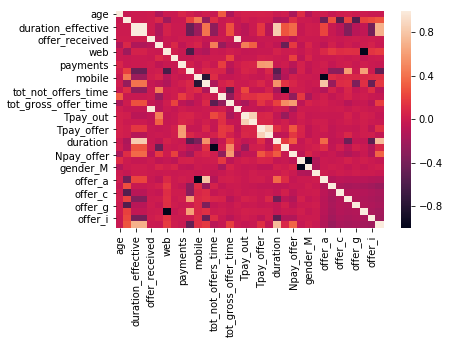

In [0]:
sns.heatmap(X.corr())
